In [1]:
%%html
<style>
table {float:left}
</style>

# Power Spectrum and Power Spectrum Density

* [1.3.2.c Interpreting a DFT plot](https://www.coursera.org/learn/dsp1/lecture/Mrwua?t=107)

> The square magnitude of the k-th DFT coefficient gives an indication of the energy associated to the frequency (2π/N)*k that composes a signal. The signal's energy at a given frequency is proportional to the magnitude of the DFT coefficient at that point.

> <img src="../image/parseval_theorem.png" align="left" width=600/>

[How to scale FFT and PSD in Matlab](https://www.youtube.com/watch?v=D67ZgH8FEAI)

<img src="../image/amplitude.png" align="left" width=800/>

<img src="../image/PSD.png" align="left" width=800/>

<img src="../image/fft_to_amplitude.png" align="left" width=600/> 

 <img src="../image/fft_to_power.png" align="left" width=600/>

<img src="../image/fft_to_psd.png" align="left" width=600/>

In [2]:
from typing import (
    Callable
)
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from scipy.fft import (
    rfft, 
    rfftfreq
)
import torch

from IPython.display import (
    Audio, 
    display
)

# Constant

In [3]:
FREQUENCY: float = 256
SAMPLING_RATE: int = 1e4 
DURATION: float = 3

# Function

In [4]:
def f(x):
    return np.sin(FREQUENCY * 2 * np.pi * x)

In [5]:
def f_amplitude(x):
    return np.abs(f(x))

In [6]:
def generate_samples(sampling_rate: float, seconds: float, func: Callable):
    x = np.linspace(0, seconds, int(sampling_rate * seconds), endpoint=False)
    return x, func(x)

In [7]:
x, y = generate_samples(sampling_rate=SAMPLING_RATE, seconds=DURATION, func=f)

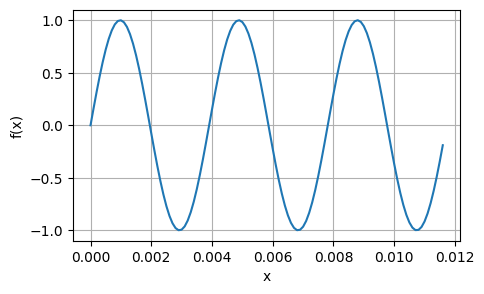

In [8]:
plt.figure(figsize=(5,3))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid()
plt.plot(x[:int(len(x) / FREQUENCY)], y[:int(len(x) / FREQUENCY)])
plt.show()

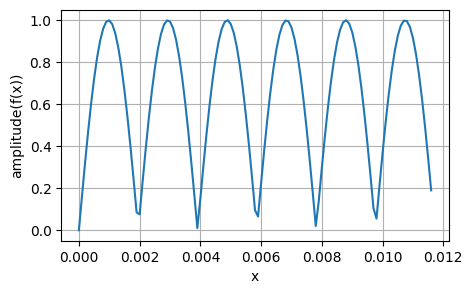

In [9]:
plt.figure(figsize=(5,3))
plt.xlabel('x')
plt.ylabel('amplitude(f(x))')
plt.grid()
plt.plot(x[:int(len(x) / FREQUENCY)], f_amplitude(x)[:int(len(x) / FREQUENCY)])
# plt.plot(x, f_amplitude(x))
plt.show()

# FFT

In [10]:
N = len(x)
assert N == int(SAMPLING_RATE * DURATION)

# Frequencies
xf = rfftfreq(
    n=N,             # window length
    d=(1/SAMPLING_RATE)    # delta(t) = sample spacing.
)

# Manitude
yf = np.abs(rfft(x=y, n=len(x))) / N

# Amplitude
a = 2 * yf

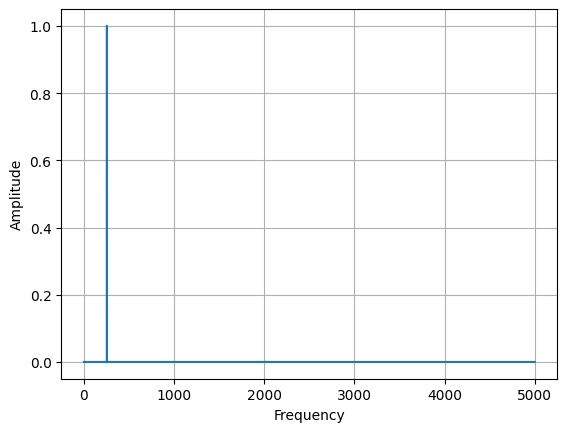

In [11]:
plt.plot(xf, a)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# Power

$
P = A^2 / 2
$

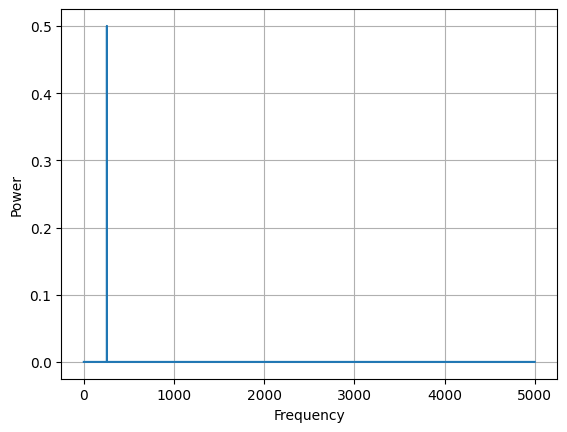

In [12]:
p = np.power(a, 2) / 2
plt.plot(xf, p)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid()
plt.show()

# Amplitude, Power, PSD

* [PSD calculation from FFT does not match with the value from scipy.signal.welch](https://dsp.stackexchange.com/questions/94571/psd-calculation-from-fft-does-not-match-with-the-value-from-scipy-signal-welch)

* [scipy.signal.get_windo](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html#scipy.signal.get_window)

> ```get_window(window, Nx, fftbins=True)```
> Return a window of a given length and type.
> * ```window```  
> The type of window to create. See below for more details.
> 
> * ```Nx```
> The number of samples in the window.
> 
> * ```fftbins```  
> If True (default), create a “periodic” window, ready to use with ifftshift and be multiplied by the result of an FFT (see also fftfreq). > If False, create a “symmetric” window, for use in filter design.

* [scipy.signal.windows.boxcar](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.boxcar.html#scipy.signal.windows.boxcar)

> ```boxcar(M, sym=True)```  
> Return a rectangular window or Dirichlet window, this is equivalent to **no window** at all.
> 
> * ```M```  
> Number of points in the output window. If zero, an empty array is returned. An exception is thrown when it is negative.
> 
> * ```sym```  
> Whether the window is symmetric. (Has no effect for boxcar.)

In [13]:
def plot(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(5,2))
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.show()

exepected amplitude 2.8284271247461903, actual amplitude 2.8305433207556727


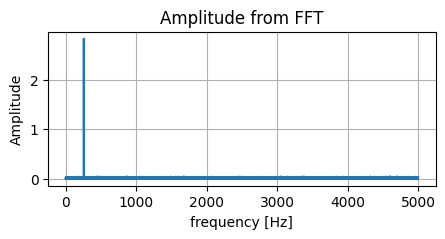

power is 4.005987745337276


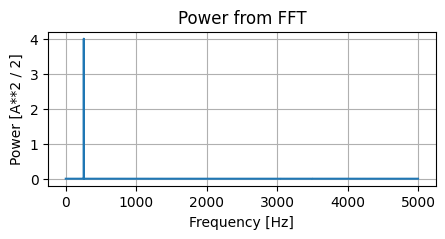

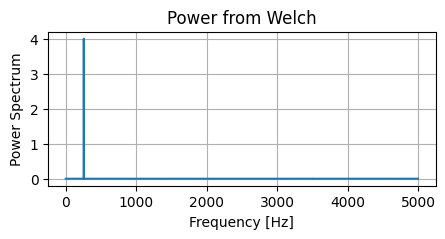

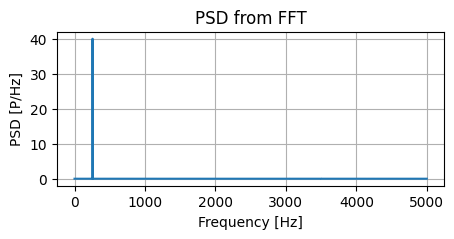

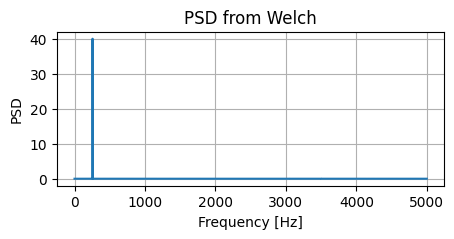

In [44]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
 
# --------------------------------------------------------------------------------
# Sampling (duration 10 secs)
# --------------------------------------------------------------------------------
FS = 1e4      # Sampling Rate
N = 1e5       # Total sample points
time = np.arange(N) / FS

# --------------------------------------------------------------------------------
# Target wave A * sin(2pi * F)
# --------------------------------------------------------------------------------
A = 2*np.sqrt(2)    # Amplitude
F = FREQUENCY       # Frequency
x = A * np.sin(2*np.pi * F * time)

# Noise
noise_power = 0.001 * FS / 2
x += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)

# --------------------------------------------------------------------------------
# FFT
# --------------------------------------------------------------------------------
freqs = np.fft.rfftfreq(time.size, 1/FS)
idx = np.argsort(freqs)
yf = np.abs(np.fft.rfft(x))

amplitude = 2 * yf / N
print(f"exepected amplitude {A}, actual amplitude {amplitude[np.argmax(amplitude)]}")
plot(freqs[idx], amplitude[idx], xlabel='frequency [Hz]', ylabel='Amplitude', title="Amplitude from FFT")

# --------------------------------------------------------------------------------
# Power Spectrum P = A**2 / 2
# --------------------------------------------------------------------------------
power = amplitude ** 2 / 2
print(f"power is {power[np.argmax(power)]}")
plot(freqs[idx], power[idx], xlabel='Frequency [Hz]', ylabel='Power [A**2 / 2]', title="Power from FFT")

# --------------------------------------------------------------------------------
# Power Spectram from Welch
# Use no segmentation and no window function to be the same with P == A**2 /2.
# --------------------------------------------------------------------------------
# f, welch_P = signal.welch(x, FS, 'flattop', 1024, scaling='spectrum')  # This apply window function per segment of 1024 samples
f, welch_P = signal.welch(
    x=x, 
    fs=FS, 
    window='boxcar',       # Window function applied on segment. Boxcar is no windowing.
    nperseg=N,             # Number of samples per window segment. No segmenetation = use entire samples.
    scaling='spectrum'
)
plot(f, welch_P, xlabel='Frequency [Hz]', ylabel='Power Spectrum', title="Power from Welch")


# --------------------------------------------------------------------------------
# PSD
# --------------------------------------------------------------------------------
psd = power * (N/FS)
plot(
    freqs[idx], 
    psd[idx],
    xlabel='Frequency [Hz]', ylabel='PSD [P/Hz]', title="PSD from FFT"
)

# --------------------------------------------------------------------------------
# PDF from Welch
# --------------------------------------------------------------------------------
# f, welch_psd = signal.welch(x, FS, 'flattop', 1024, scaling='density')
f, welch_psd = signal.welch(
    x=x, 
    fs=FS, 
    window='boxcar',       # No window function
    nperseg=N,             # No segmentation window = use entire samples N
    scaling='density'
)
plot(f, welch_psd, xlabel='Frequency [Hz]', ylabel='PSD', title="PSD from Welch")

# PSD [db/Hz]

* [matplotlib.axes.Axes.psd](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.psd.html#matplotlib.axes.Axes.psd)

16.02709616415236

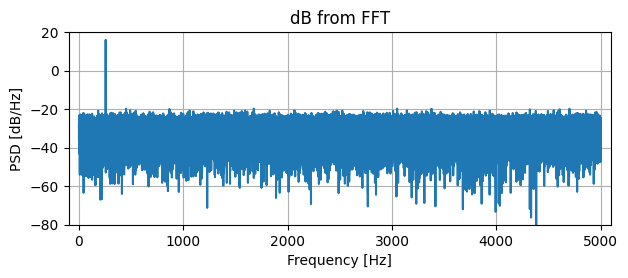

In [75]:
# --------------------------------------------------------------------------------
# PSD[db/Hz] = 10 * log10(PSD)
# --------------------------------------------------------------------------------
psd = power * (N/FS)
plt.figure(figsize=(7,2.5))
ax = plt.gca()
ax.set_xlim([0-100, np.max(freqs[idx])+100])
ax.set_ylim([-80, 20])

plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [dB/Hz]')
plt.title("dB from FFT")
plt.grid()
plt.plot(
    freqs[idx], 
    10 * np.log10(psd[idx])
)
np.max(10 * np.log10(psd[idx]))

16.02709616415236

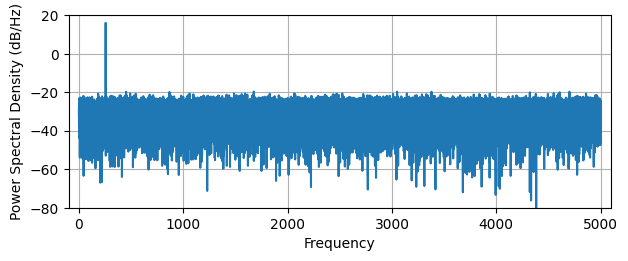

In [79]:
plt.figure(figsize=(7,2.5))
ax = plt.gca()
ax.set_xlim([0-100, np.max(freqs[idx])+100])
ax.set_ylim([-80, 20])

Pxx, frequencies = ax.psd(
    x=x, 
    Fs=FS, 
    window=signal.windows.boxcar(M=int(N)),
    sides='onesided',
    scale_by_freq=True,
    NFFT=int(N)
)
np.max(10 * np.log10(Pxx))